In [ ]:
import pandas as pd

In [ ]:
!pip install tensorflow
!pip install keras
!pip install sklearn
!pip install Pillow
!pip install pandas

# CLONE REPO CON DATA

In [ ]:
BRANCH="main"
INIT_FROM_REPO=True

if INIT_FROM_REPO:
    !git clone -b $BRANCH https://github.com/alexiscaspell/UTN-IA-dataset-armas.git
    !pip install -r UTN-IA-dataset-armas/requirements.txt
    %cd UTN-IA-dataset-armas/

%cd Sohas_weapon-Detection/

Cloning into 'UTN-IA-dataset-armas'...
remote: Enumerating objects: 11822, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 11822 (delta 1), reused 11 (delta 1), pack-reused 11811
Receiving objects: 100% (11822/11822), 1.70 GiB | 36.73 MiB/s, done.
Resolving deltas: 100% (5444/5444), done.
Checking out files: 100% (11805/11805), done.
/content/UTN-IA-dataset-armas
/content/UTN-IA-dataset-armas/Sohas_weapon-Detection


# FUNCIONES COMUNES

In [ ]:
import xmltodict
def xml_to_dict(xml_path:str)->dict: 
  with open(xml_path, 'r') as myfile:
    return xmltodict.parse(myfile.read(),xml_attribs=False)

def get_from_dict(sd:dict,key:str,default_values:list):
  result=sd

  for i,subkey in enumerate(key.split(".")):
    if isinstance(result,list):
      result = {} if len(result)==0 else result[0]
    result=result.get(subkey,default_values[i])

  return result

def simplified_dict(some_dict:dict)->dict:
  sd=some_dict["annotation"]
  return {
      "path": f"{sd['folder']}/{sd['filename']}",
      "width": sd["size"]["width"],
      "height": sd["size"]["height"],
      "depth": sd["size"]["depth"],
      "segmented": sd["segmented"],
      "pose":get_from_dict(sd,"object.pose",[{},"Unspecified"]),
      "object":get_from_dict(sd,"object.name",[{},"Unspecified"]),
      "truncated":get_from_dict(sd,"object.truncated",[{},0]),
      "xmin":get_from_dict(sd,"object.bndbox.xmin",[{},{},None]),
      "xmax":get_from_dict(sd,"object.bndbox.xmax",[{},{},None]),
      "ymin":get_from_dict(sd,"object.bndbox.ymin",[{},{},None]),
      "ymax":get_from_dict(sd,"object.bndbox.ymax",[{},{},None])
  }

# CARGA DE XMLS A DICTS

In [ ]:
import os

BRANCH="main"
PATH_XMLS="annotations_test/xmls" if BRANCH=="test" else "annotations/xmls"

xml_objects=[]

for filename in os.listdir(PATH_XMLS):
    if filename.endswith('.xml'):
        fullname = os.path.join(PATH_XMLS, filename)
        some_dict=xml_to_dict(fullname)
        xml_objects.append(simplified_dict(some_dict))

# CARGA DE DATAFRAME

In [ ]:
df_data = pd.DataFrame.from_dict(xml_objects, orient='columns')
df_data.head()

,path,width,height,depth,segmented,pose,object,truncated,xmin,xmax,ymin,ymax
0,Definitiva/pistol_2888.jpg,450,450,3,0,Unspecified,pistol,0,17,246,127,277
1,images/ABmframe00313.jpg,1920,1090,3,0,Unspecified,knife,0,504,590,498,591
2,Nueva carpeta (3)/smartphone_0428.jpg,1021,1530,3,0,Unspecified,smartphone,0,172,851,413,1063
3,Train-P2/RusoClases310.jpg,1280,720,3,0,Unspecified,knife,0,595,644,332,495
4,Nueva carpeta/smartphone_0264.jpg,1600,1200,3,0,Unspecified,smartphone,0,344,906,95,1115


# LIMPIEZA

## FORMATEO NUEVAS COLUMNAS

In [ ]:
WEAPONS_TYPES=["knife","pistol"]

df = df_data.copy()
df["path"] = df["path"].apply(lambda p: p.split("/")[-1])
df["weapon"] = df["object"].apply(lambda o: 1 if o in WEAPONS_TYPES else 0)

df["xmin"]=df["xmin"].astype(float)
df["xmax"]=df["xmax"].astype(float)
df["ymin"]=df["ymin"].astype(float)
df["ymax"]=df["ymax"].astype(float)
df["weapon"]=df["weapon"].astype(float)
df["o_width"]= df["xmax"]-df["xmin"]
df["o_height"]= df["ymax"]-df["ymin"]

df.head()

,path,width,height,depth,segmented,pose,object,truncated,xmin,xmax,ymin,ymax,weapon,o_width,o_height
0,pistol_2888.jpg,450,450,3,0,Unspecified,pistol,0,17.0,246.0,127.0,277.0,1.0,229.0,150.0
1,ABmframe00313.jpg,1920,1090,3,0,Unspecified,knife,0,504.0,590.0,498.0,591.0,1.0,86.0,93.0
2,smartphone_0428.jpg,1021,1530,3,0,Unspecified,smartphone,0,172.0,851.0,413.0,1063.0,0.0,679.0,650.0
3,RusoClases310.jpg,1280,720,3,0,Unspecified,knife,0,595.0,644.0,332.0,495.0,1.0,49.0,163.0
4,smartphone_0264.jpg,1600,1200,3,0,Unspecified,smartphone,0,344.0,906.0,95.0,1115.0,0.0,562.0,1020.0


## ELIMINACION COLUMNAS INNECESARIAS

In [ ]:
df = df.drop(labels="depth", axis=1)
df = df.drop(labels="segmented", axis=1)
df = df.drop(labels="pose", axis=1)
df = df.drop(labels="truncated", axis=1)
#df = df.drop(labels="object", axis=1)
df = df.drop(labels="width", axis=1)
df = df.drop(labels="height", axis=1)

df.head()

,path,object,xmin,xmax,ymin,ymax,weapon,o_width,o_height
0,pistol_2888.jpg,pistol,17.0,246.0,127.0,277.0,1.0,229.0,150.0
1,ABmframe00313.jpg,knife,504.0,590.0,498.0,591.0,1.0,86.0,93.0
2,smartphone_0428.jpg,smartphone,172.0,851.0,413.0,1063.0,0.0,679.0,650.0
3,RusoClases310.jpg,knife,595.0,644.0,332.0,495.0,1.0,49.0,163.0
4,smartphone_0264.jpg,smartphone,344.0,906.0,95.0,1115.0,0.0,562.0,1020.0


# CARGA DATASET A ENTRADA NN

In [ ]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D,Conv2D
from keras.utils import np_utils
from keras.preprocessing.image import  img_to_array
from random import randint

import numpy as np

# Image manipulations and arranging data
import os
from PIL import Image
# import theano
# theano.config.optimizer="None"
#Sklearn to modify the data

from sklearn.model_selection import train_test_split

In [ ]:
#m,n = int(df["o_width"].median()),int(df["o_height"].median())
m,n=150,150

PATH_SEP="/"

path1='images_test'
path2='images'

classes=list(df["object"].unique())

In [ ]:
def get_image_metadata(img_name:str):
    xmin=df[df["path"]==img_name]["xmin"].values[0]
    xmax=df[df["path"]==img_name]["xmax"].values[0]
    ymin=df[df["path"]==img_name]["ymin"].values[0]
    ymax=df[df["path"]==img_name]["ymax"].values[0]
    weapon=df[df["path"]==img_name]["weapon"].values[0]
    width=df[df["path"]==img_name]["o_width"].values[0]
    height=df[df["path"]==img_name]["o_height"].values[0]
    object=df[df["path"]==img_name]["object"].values[0]
    
    return [int(xmin),int(ymax),int(xmax),int(ymin),weapon,int(width),int(height),object]

def get_dummy_metadata(img):
    object=None
    for c in classes:
        if c in img:
            object=c
            break
            
    if object is None:
        raise RuntimeError("Objeto no identificado")
        
    xmin=0
    ymin=0
    ymax=n
    xmax=m
    width=m
    heigth=n
    weapon=False
    
    return [int(xmin),int(ymax),int(xmax),int(ymin),weapon,int(width),int(height),object]

In [ ]:
# Dependencies
import os
import numpy as np, cv2
from matplotlib import pyplot as plt
from functools import reduce
from google.colab.patches import cv2_imshow
import time

# Functions

def compose(*func):    
    def compose_f(f, g):
        return lambda x : f(g(x))
    return reduce(compose_f, func, lambda x : x)

def resize(img_src):
  width = 150
  height = 150
  dsize = (width, height)
  img_resize = cv2.resize(img_src, dsize)
  return img_resize

def denois(img_src):
  res = cv2.fastNlMeansDenoisingColored(img_src, None, 20, 20, 14, 42)
  return res

def equalizeColor(img_src):
  r_image, g_image, b_image = cv2.split(img_src)
  image_eq = cv2.merge((
      cv2.equalizeHist(r_image), 
      cv2.equalizeHist(g_image), 
      cv2.equalizeHist(b_image)))
  return image_eq

def equalizeGray(img_src):
  return cv2.equalizeHist(img_src)

def gray(img_src):
  res = cv2.cvtColor(img_src, cv2.COLOR_RGB2GRAY)
  return res

def segment(img_src):
  ret, img_seg = cv2.threshold(img_src, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
  return img_seg

def open(path):
  img_src = cv2.imread(path)
  img_src = cv2.cvtColor(img_src, cv2.COLOR_BGR2RGB)
  return img_src

def toRgbFormat(img_src):
  img_rgb_format = cv2.cvtColor(img_src,cv2.COLOR_GRAY2RGB)
  return img_rgb_format

#Processing
def process(img):
  return compose(toRgbFormat,segment,gray,resize,open)(img)

def show(name):
  def to_show(img_src):
    print(name)
    cv2_imshow(img_src)
    return img_src
  return to_show

# Example
# output = compose(show('OUTPUT'),process)('Pistol.jpg')

In [ ]:
x=[]
y=[]

FORCE_IMAGE_INFERENCE=False
CROP_IMAGE=False
AUGMENTATION_ACTIVE=False
                      
augment_classes=list(filter(lambda c:c not in ["knife","pistol"],classes))

imgfiles = list(df["path"])
count=0
augmented=0

for img in imgfiles:
    try:
        try:
            metadata=None
            metadata=get_image_metadata(img)
        except:
            if FORCE_IMAGE_INFERENCE:
                pass
            raise RuntimeError("Invalid metadata")
        
        if metadata is None:
            metadata=get_dummy_metadata(img)
        
        if CROP_IMAGE:
            if metadata[5]<m or metadata[6]<n:
                continue     
        #new process
        imrs = process(path2+PATH_SEP+img)
        imrs = imrs/255
        imrs = imrs.transpose(2,0,1)
        imrs = imrs.reshape(3,m,n)
        x.append(imrs)
        y.append(classes.index(metadata[7]))
        count+=1
        '''
        im=Image.open(path2+PATH_SEP+img)
        im=im.convert(mode='RGB')
        
        if CROP_IMAGE:
            im = im.crop((metadata[0],metadata[1],metadata[2],metadata[3]))

        imrs=im.resize((m,n))
        print(img_to_array(imrs))
        imrs=img_to_array(imrs)/255
        imrs=imrs.transpose(2,0,1)
        imrs=imrs.reshape(3,m,n)

        x.append(imrs)
        y.append(classes.index(metadata[7]))
        count+=1
        print(count)
        '''   
        if AUGMENTATION_ACTIVE and (metadata[7] in augment_classes):
          for i in range(2):
            im = im.rotate(randint(1,90), Image.NEAREST, expand = 1)
            imrs=im.resize((m,n))
            imrs=img_to_array(imrs)/255
            imrs=imrs.transpose(2,0,1)
            imrs=imrs.reshape(3,m,n)
            x.append(imrs)
            y.append(classes.index(metadata[7]))
            augmented+=1
    except Exception as e:
        pass
        print(e)
    
print(f"CARGADAS {count}/{len(imgfiles)} IMAGENES")
print(f"AUGMENTED: {augmented}")

x=np.array(x)
y=np.array(y)

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.

In [ ]:
nb_classes=len(np.unique(y))
#nb_classes=1
nb_filters=128
nb_pool=2
nb_conv=3

x_train, x_test, y_train, y_test= train_test_split(x,y,test_size=0.2,random_state=4)

In [ ]:
uniques, id_train=np.unique(y_train,return_inverse=True)
Y_train=np_utils.to_categorical(id_train,nb_classes)
uniques, id_test=np.unique(y_test,return_inverse=True)
Y_test=np_utils.to_categorical(id_test,nb_classes)
#Y_train=y_train
#Y_test=y_test

In [ ]:
model= Sequential()

model.add(Convolution2D(nb_filters,nb_conv,nb_conv,padding='same',input_shape=x_train.shape[1:]))
model.add(Activation('relu'))

model.add(Convolution2D(int(nb_filters/2),nb_conv,nb_conv,padding='same'))
model.add(Activation('relu'))

model.add(Dropout(0.2))

model.add(Convolution2D(int(nb_filters/4),nb_conv,nb_conv,padding='same'))
model.add(Activation('relu'))

model.add(Convolution2D(int(nb_filters/8),nb_conv,nb_conv,padding='same'))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(nb_pool,nb_pool), padding='same'))

model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128))

model.add(Dropout(0.2))

model.add(Dense(nb_classes))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])

In [ ]:
#nb_epoch=120
#batch_size=40
nb_epoch=60
batch_size=60
history = model.fit(x_train,Y_train,batch_size=batch_size,epochs=nb_epoch,verbose=1,validation_data=(x_test, Y_test))

model.save("model_latest.h5",overwrite=True)
model_cached=False

Epoch 1/60
65/65 [==============================] - 7s 96ms/step - loss: 1.6441 - accuracy: 0.3582 - val_loss: 1.5722 - val_accuracy: 0.3515
Epoch 2/60
65/65 [==============================] - 6s 92ms/step - loss: 1.5249 - accuracy: 0.3798 - val_loss: 1.5426 - val_accuracy: 0.3515
Epoch 3/60
65/65 [==============================] - 6s 91ms/step - loss: 1.5124 - accuracy: 0.3950 - val_loss: 1.5261 - val_accuracy: 0.3845
Epoch 4/60
65/65 [==============================] - 6s 91ms/step - loss: 1.4813 - accuracy: 0.4283 - val_loss: 1.5114 - val_accuracy: 0.4113
Epoch 5/60
65/65 [==============================] - 6s 92ms/step - loss: 1.4698 - accuracy: 0.4590 - val_loss: 1.4981 - val_accuracy: 0.4495
Epoch 6/60
65/65 [==============================] - 6s 90ms/step - loss: 1.4428 - accuracy: 0.4706 - val_loss: 1.4728 - val_accuracy: 0.4701
Epoch 7/60
65/65 [==============================] - 6s 92ms/step - loss: 1.4353 - accuracy: 0.4825 - val_loss: 1.4516 - val_accuracy: 0.4763
Epoch 8/60
65

In [ ]:
# exactitud

# error




MODEL: model_latest.h5


ARCHIVO: pistola_z3v2_09.jpg

PISTOL: 28.49%
KNIFE: 14.26%
SMARTPHONE: 13.24%
BILLETE: 27.2%
TARJETA: 9.05%
MONEDERO: 7.76%


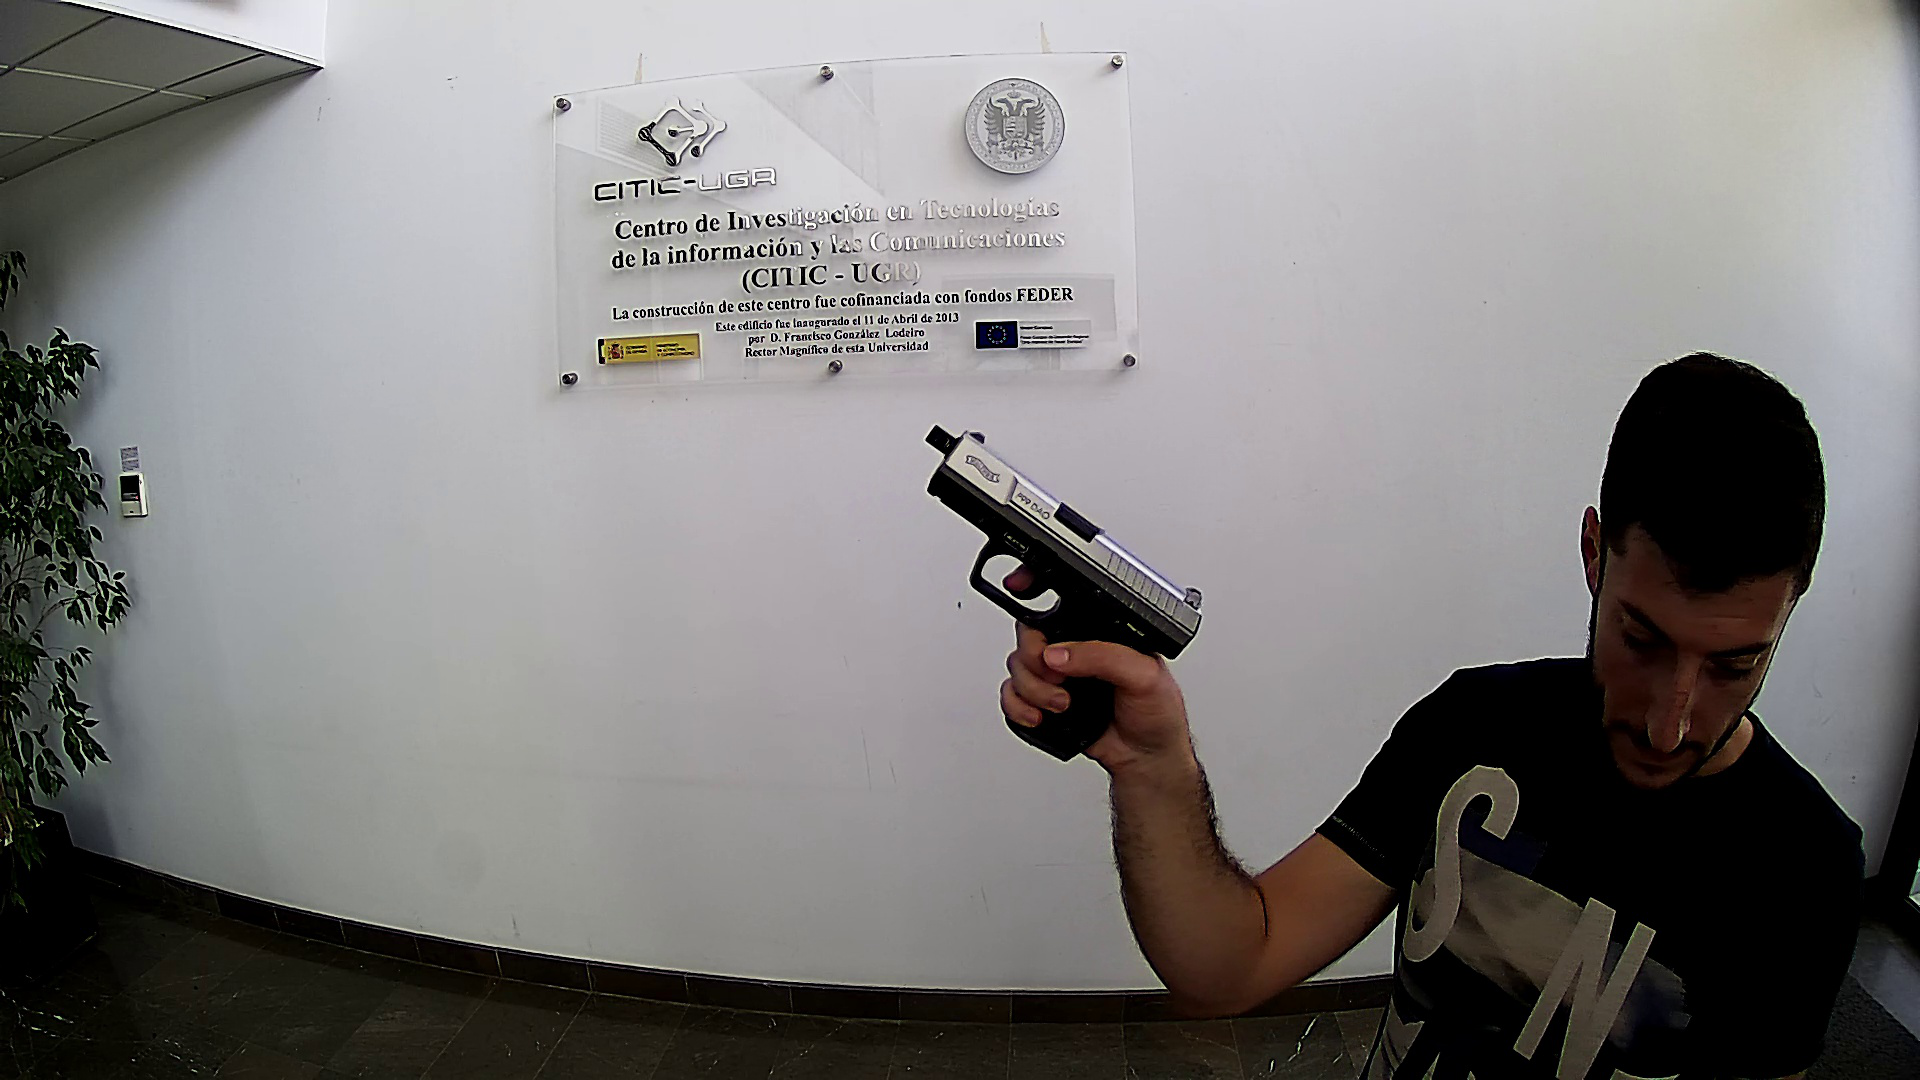

In [ ]:
from keras.models import load_model

MODEL_VERSION="v1.1"
MODEL_VERSION="latest"

model_version= None if not model_cached else model_version

if model_version is None or model_version!=MODEL_VERSION:
  model_cached=True
  model_version=MODEL_VERSION 
  model_file=f"model_{model_version}.h5"
  model = load_model(model_file)

files=os.listdir(path1)

# img="img4232.jpg"

img=files[randint(0,len(files)-1)]

im = Image.open(path1 +PATH_SEP+ img)


#imrs = im.resize((300,300))
#imrs=img_to_array(imrs)/255
#imrs=imrs.transpose(2,0,1)
#imrs=imrs.reshape(3,300,300)

imrs = process(path1 +PATH_SEP+ img)
imrs = imrs/255
imrs = imrs.transpose(2,0,1)
imrs = imrs.reshape(3,m,n)
x=[]
x.append(imrs)
x=np.array(x)

predictions = model.predict(x)

print (f"\nMODEL: {model_file}\n")

print (f"\nARCHIVO: {img}\n")
#print (f"PROBABILIDAD DE ARMA: {round(predictions.flat[0]*100,2)}%")
for i,e in enumerate(list(predictions)[0]):
    print(f"{classes[i].upper()}: {round(e*100,2)}%")

#print (model.summary())

im

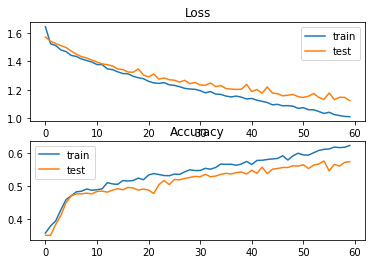

In [ ]:
# Graphics

# plot loss during training
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix

def isWeapon(index):
  return int(classes[index] in ['knife','pistol'])

y_pred = model.predict(x_test)
y_pred = np.apply_along_axis(np.argmax, 1, y_pred)

confusion = confusion_matrix(y_test, y_pred)
print('Confusion Matrix multiclass\n')
print(confusion)

vec_function = np.vectorize(isWeapon)
y_pred_binary = vec_function(y_pred)
y_test_binary = vec_function(y_test)

confusion = confusion_matrix(y_test_binary, y_pred_binary)
print('Confusion Matrix weapon or not\n')
print(confusion)

# calc
TP = confusion[0][0]
TN = confusion[1][1]
FP = confusion[0][1]
FN = confusion[1][0]

print('Accurancy')
print((TP+TN)/(TP+TN+FP+FN))

Confusion Matrix multiclass

[[212  35   6   0   0  19]
 [ 77 251   8   1   0   4]
 [ 64  19  29   1   0  15]
 [ 56  11   7   5   0  12]
 [ 25   6   3   2   0   5]
 [ 22   8   8   0   0  59]]
Confusion Matrix weapon or not

[[146 211]
 [ 38 575]]
Accurancy
0.743298969072165
